# New Section

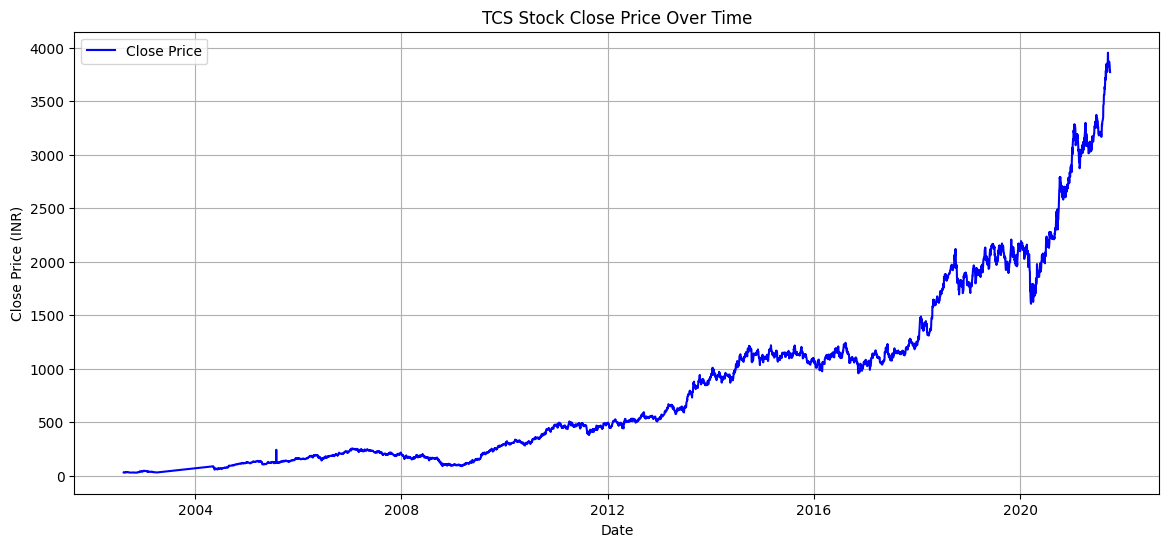

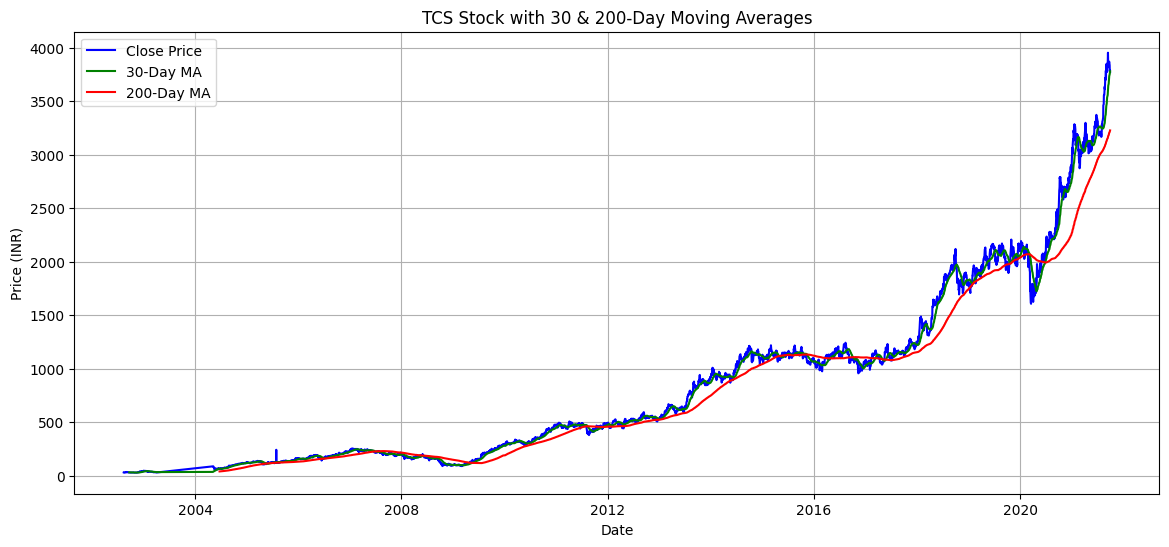

In [ ]:
# 📊 TCS Stock Analysis & Forecasting Report

# 📌 Phase 1: Data Cleaning & Exploration

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Upload file from: /content
df = pd.read_csv('/content/TCS_stock_history.csv')

# Convert Date column to datetime
df['Date'] = pd.to_datetime(df['Date'])

# Sort by date
df = df.sort_values('Date')

# Drop missing values
df.dropna(inplace=True)

# Plot Closing Price over time
plt.figure(figsize=(14, 6))
plt.plot(df['Date'], df['Close'], label='Close Price', color='blue')
plt.title('TCS Stock Close Price Over Time')
plt.xlabel('Date')
plt.ylabel('Close Price (INR)')
plt.legend()
plt.grid(True)
plt.show()

# Add 30-day and 200-day moving averages
df['MA30'] = df['Close'].rolling(window=30).mean()
df['MA200'] = df['Close'].rolling(window=200).mean()

# Plot with Moving Averages
plt.figure(figsize=(14, 6))
plt.plot(df['Date'], df['Close'], label='Close Price', color='blue')
plt.plot(df['Date'], df['MA30'], label='30-Day MA', color='green')
plt.plot(df['Date'], df['MA200'], label='200-Day MA', color='red')
plt.title('TCS Stock with 30 & 200-Day Moving Averages')
plt.xlabel('Date')
plt.ylabel('Price (INR)')
plt.legend()
plt.grid(True)
plt.show()


<ipython-input-2-d699d0c26b1e>:21: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  df['Signal'][df['MA30'] > df['MA200']] = 1  # Buy
<ipython-input-2-d699d0c26b1e>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice f

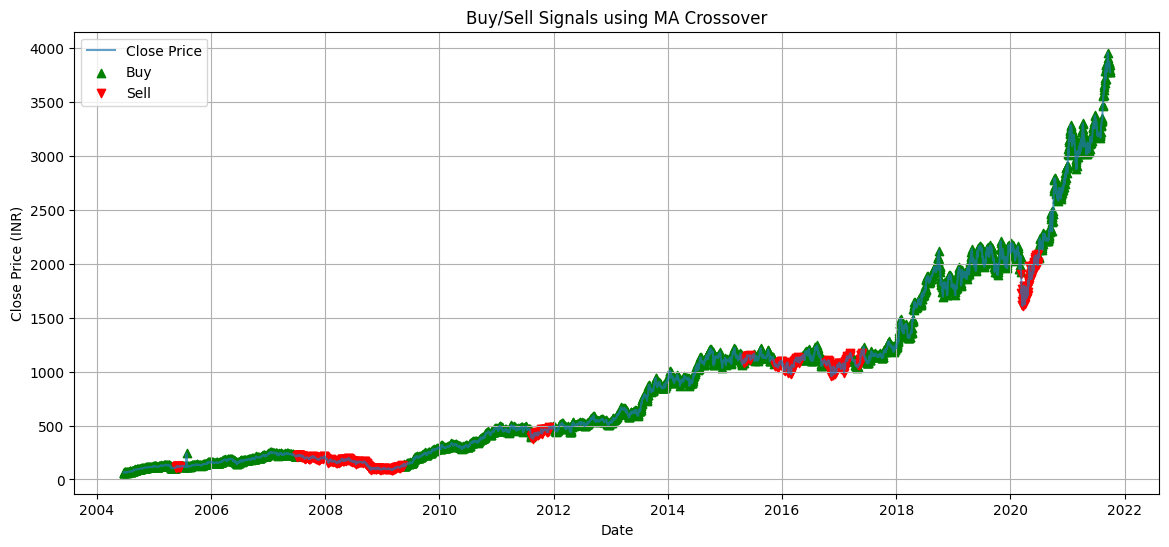

In [ ]:
# 📌 Phase 2: Feature Engineering & Signal Creation

import numpy as np

# 1. Create time-based features: Year, Month, Weekday
df['Year'] = df['Date'].dt.year
df['Month'] = df['Date'].dt.month
df['Weekday'] = df['Date'].dt.day_name()

# 2. Calculate daily returns (% change in closing price)
df['Daily_Return (%)'] = df['Close'].pct_change() * 100

# 3. Calculate 30-day price volatility (rolling std deviation)
df['Volatility_30D'] = df['Close'].rolling(window=30).std()

# Drop first few rows with NaN (from rolling calculations)
df.dropna(inplace=True)

# 4. Create Buy/Sell signals using MA Crossover (30-day vs 200-day)
df['Signal'] = 0
df['Signal'][df['MA30'] > df['MA200']] = 1  # Buy
df['Signal'][df['MA30'] < df['MA200']] = -1  # Sell

# 5. Visualize Close Price with Buy/Sell signals
plt.figure(figsize=(14, 6))
plt.plot(df['Date'], df['Close'], label='Close Price', alpha=0.7)

# Plot buy signals
buy_signals = df[df['Signal'] == 1]
plt.scatter(buy_signals['Date'], buy_signals['Close'], label='Buy', marker='^', color='green')

# Plot sell signals
sell_signals = df[df['Signal'] == -1]
plt.scatter(sell_signals['Date'], sell_signals['Close'], label='Sell', marker='v', color='red')

plt.title('Buy/Sell Signals using MA Crossover')
plt.xlabel('Date')
plt.ylabel('Close Price (INR)')
plt.legend()
plt.grid(True)
plt.show()


In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score


In [ ]:
# Select input columns (features) and the target column
features = ['Open', 'High', 'Low', 'Volume', 'MA30', 'MA200']
X = df[features]         # Input features
y = df['Close']          # Target variable (what we want to predict)


In [ ]:
# Split into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [ ]:
# Create the model
model = LinearRegression()

# Train it using training data
model.fit(X_train, y_train)


LinearRegression()

In [ ]:
# Predict Close prices on test data
y_pred = model.predict(X_test)


In [ ]:
# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("📉 Mean Squared Error (MSE):", round(mse, 2))
print("📈 R-squared Score (R²):", round(r2, 4))


📉 Mean Squared Error (MSE): 40.78
📈 R-squared Score (R²): 0.9999


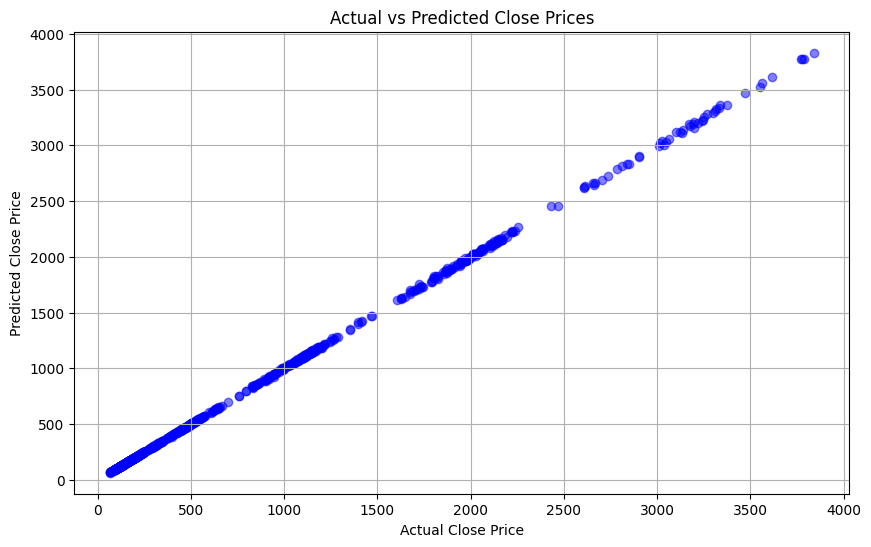

In [ ]:
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, color='blue', alpha=0.5)
plt.xlabel('Actual Close Price')
plt.ylabel('Predicted Close Price')
plt.title('Actual vs Predicted Close Prices')
plt.grid(True)
plt.show()


In [ ]:
import pickle


In [ ]:
# Save the model as a file
with open('TCS_Linear_Model.pkl', 'wb') as file:
    pickle.dump(model, file)

print("✅ Model saved successfully as TCS_Linear_Model.pkl")


✅ Model saved successfully as TCS_Linear_Model.pkl


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense


In [ ]:
# Use only the 'Close' column
close_data = df[['Close']].values

# Normalize the values between 0 and 1
scaler = MinMaxScaler()
close_scaled = scaler.fit_transform(close_data)


In [ ]:
X = []
y = []

for i in range(60, len(close_scaled)):
    X.append(close_scaled[i-60:i, 0])  # Past 60 values
    y.append(close_scaled[i, 0])       # Next value

X = np.array(X)
y = np.array(y)

# Reshape for LSTM: (samples, timesteps, features)
X = np.reshape(X, (X.shape[0], X.shape[1], 1))


In [ ]:
model = Sequential()
model.add(LSTM(units=50, input_shape=(X.shape[1], 1)))
model.add(Dense(1))  # Predict 1 value
model.compile(optimizer='adam', loss='mean_squared_error')


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [ ]:
model.fit(X, y, epochs=10, batch_size=32)


Epoch 1/10
132/132 ━━━━━━━━━━━━━━━━━━━━ 7s 26ms/step - loss: 0.0240
Epoch 2/10
132/132 ━━━━━━━━━━━━━━━━━━━━ 3s 22ms/step - loss: 1.4360e-04
Epoch 3/10
132/132 ━━━━━━━━━━━━━━━━━━━━ 3s 22ms/step - loss: 1.2171e-04
Epoch 4/10
132/132 ━━━━━━━━━━━━━━━━━━━━ 6s 30ms/step - loss: 1.5157e-04
Epoch 5/10
132/132 ━━━━━━━━━━━━━━━━━━━━ 4s 22ms/step - loss: 1.3188e-04
Epoch 6/10
132/132 ━━━━━━━━━━━━━━━━━━━━ 3s 22ms/step - loss: 1.1514e-04
Epoch 7/10
132/132 ━━━━━━━━━━━━━━━━━━━━ 4s 27ms/step - loss: 1.0524e-04
Epoch 8/10
132/132 ━━━━━━━━━━━━━━━━━━━━ 4s 22ms/step - loss: 9.7882e-05
Epoch 9/10
132/132 ━━━━━━━━━━━━━━━━━━━━ 3s 22ms/step - loss: 9.7861e-05
Epoch 10/10
132/132 ━━━━━━━━━━━━━━━━━━━━ 3s 22ms/step - loss: 8.6251e-05


In [ ]:
# Use last 160 days to generate test inputs
test_input = close_scaled[-160:]

X_test = []

for i in range(60, len(test_input)):
    X_test.append(test_input[i-60:i, 0])

X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

# Predict using trained model
predicted_scaled = model.predict(X_test)

# Convert back to real price
predicted_prices = scaler.inverse_transform(predicted_scaled)



4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 146ms/step


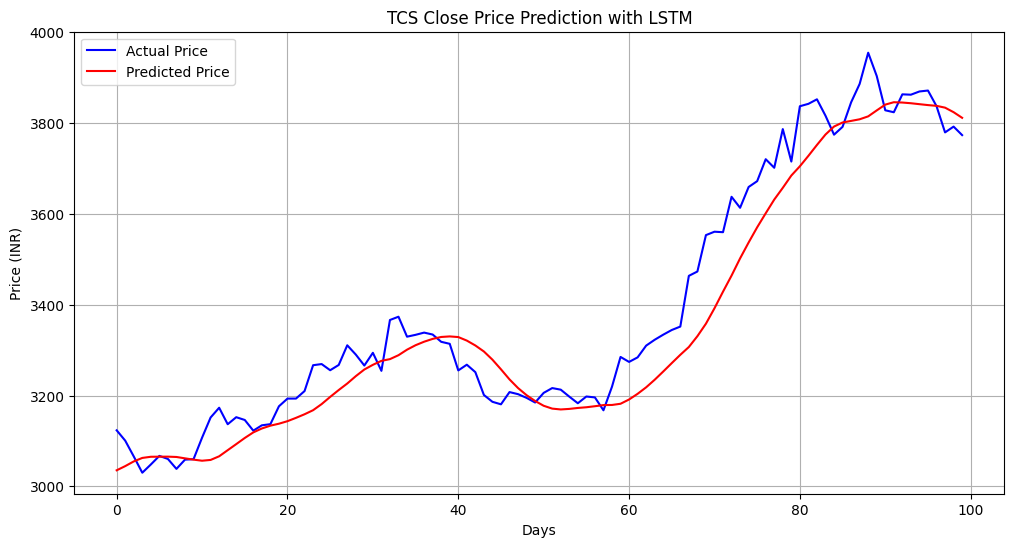

In [ ]:
actual_prices = scaler.inverse_transform(test_input[60:])

plt.figure(figsize=(12, 6))
plt.plot(actual_prices, label='Actual Price', color='blue')
plt.plot(predicted_prices, label='Predicted Price', color='red')
plt.title('TCS Close Price Prediction with LSTM')
plt.xlabel('Days')
plt.ylabel('Price (INR)')
plt.legend()
plt.grid(True)
plt.show()



In [ ]:
mae = mean_absolute_error(actual_prices, predicted_prices)
print("LSTM Mean Absolute Error (MAE): ₹", round(mae, 2))


LSTM Mean Absolute Error (MAE): ₹ 56.83


In [ ]:
# Save the trained LSTM model
model.save("TCS_LSTM_Model.h5")
print("✅ LSTM model saved as TCS_LSTM_Model.h5")


✅ LSTM model saved as TCS_LSTM_Model.h5


In [ ]:
# Compare LSTM vs Linear Regression
# y_test = actual Close prices from test set
# y_pred = predictions from Linear Regression


In [ ]:
from sklearn.metrics import mean_absolute_error

# Linear Regression MAE (from previous phase)
mae_lr = mean_absolute_error(y_test, y_pred)

# LSTM MAE (calculated already)
mae_lstm = mean_absolute_error(actual_prices, predicted_prices)

print("📉 Linear Regression MAE:", round(mae_lr, 2))
print("📈 LSTM MAE:", round(mae_lstm, 2))


📉 Linear Regression MAE: 3.89
📈 LSTM MAE: 56.83


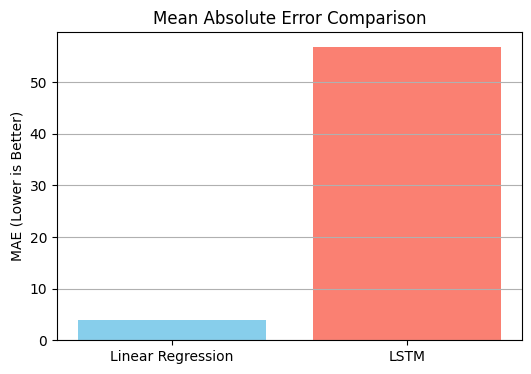

In [ ]:
plt.figure(figsize=(6, 4))
plt.bar(['Linear Regression', 'LSTM'], [mae_lr, mae_lstm], color=['skyblue', 'salmon'])
plt.title('Mean Absolute Error Comparison')
plt.ylabel('MAE (Lower is Better)')
plt.grid(axis='y')
plt.show()


In [ ]:
Day 1   Day 2   Day 3   ...   Day 59  Day 60
  |       |       |     ...     |       |
  +-------+-------+-------------+-------+-----> LSTM uses this sequence to predict:
                                                ⬇
                                           Day 61 Price
[Day 1 → 60] → Predict 61
[Day 2 → 61] → Predict 62
[Day 3 → 62] → Predict 63

[Close Prices Day 1-60] —> 🧠 LSTM Cell —> 📊 Predicted Day 61
                                ↑
                      Memory + Gates Logic







In [ ]:
# For LSTM predictions
lstm_output = pd.DataFrame({
    'Actual_Close': actual_prices.flatten(),
    'Predicted_Close_LSTM': predicted_prices.flatten()
})

lstm_output.to_csv('LSTM_predictions.csv', index=False)

# To download in Colab
from google.colab import files
files.download('LSTM_predictions.csv')


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
!pip install streamlit pyngrok --quiet


In [ ]:
app_code = """
import streamlit as st
import pandas as pd
import matplotlib.pyplot as plt
import pickle
import os

st.set_page_config(page_title="TCS Stock Dashboard", layout="wide")
st.title("📈 TCS Stock Price Visualizer & Predictor")

uploaded_file = st.file_uploader("Upload your TCS CSV file", type=["csv"])

if uploaded_file is not None:
    df = pd.read_csv(uploaded_file)
    df['Date'] = pd.to_datetime(df['Date'])
    df = df.sort_values('Date')

    st.subheader("📊 Close Price Over Time")
    fig, ax = plt.subplots(figsize=(12, 5))
    ax.plot(df['Date'], df['Close'], label='Close Price', color='blue')
    ax.set_title("TCS Close Price Trend")
    ax.set_xlabel("Date")
    ax.set_ylabel("Close Price (INR)")
    ax.legend()
    st.pyplot(fig)

    df['MA30'] = df['Close'].rolling(window=30).mean()
    df['MA200'] = df['Close'].rolling(window=200).mean()

    st.subheader("📈 Moving Averages")
    fig2, ax2 = plt.subplots(figsize=(12, 5))
    ax2.plot(df['Date'], df['Close'], label='Close', color='blue')
    ax2.plot(df['Date'], df['MA30'], label='MA30', color='green')
    ax2.plot(df['Date'], df['MA200'], label='MA200', color='red')
    ax2.set_title("30 & 200-Day Moving Averages")
    ax2.set_xlabel("Date")
    ax2.set_ylabel("Price")
    ax2.legend()
    st.pyplot(fig2)

    features = ['Open', 'High', 'Low', 'Volume', 'MA30', 'MA200']
    try:
        with open("TCS_Linear_Model.pkl", "rb") as f:
            model = pickle.load(f)

        missing_cols = [col for col in features if col not in df.columns]
        if missing_cols:
            st.error(f"Missing columns: {missing_cols}")
        else:
            recent_data = df[features].dropna().tail(10)
            if recent_data.empty:
                st.warning("Not enough data for prediction.")
            else:
                predictions = model.predict(recent_data)
                output = df[['Date']].iloc[-10:].copy()
                output['Predicted Close'] = predictions
                st.subheader("🔮 Predicted Close Price (Last 10 Days)")
                st.dataframe(output)
                st.line_chart(output.set_index('Date'))
    except Exception as e:
        st.error(f"Error loading model: {e}")
else:
    st.info("👈 Please upload your CSV file.")
"""

# Save this to app.py in Colab
with open("app.py", "w") as f:
    f.write(app_code)


In [ ]:
from google.colab import files
uploaded = files.upload()


Saving TCS_Linear_Model.pkl to TCS_Linear_Model (1).pkl


In [ ]:
from pyngrok import ngrok

# Only run once after signup
ngrok.set_auth_token("2xAt5D4gQYZQsfgBU9oJATVVe5b_5q876Svg8WPZvTfg2fc8Y")


In [ ]:
from pyngrok import ngrok

# Start the streamlit app in the background
import os
os.system("streamlit run app.py &")

# ✅ FIX: Use `ngrok.connect()` with proper keyword
public_url = ngrok.connect(addr=8501, proto="http")  # <-- use addr instead of port
print("🚀 Streamlit app is live at:", public_url)


🚀 Streamlit app is live at: NgrokTunnel: "https://9969-35-221-172-67.ngrok-free.app" -> "http://localhost:8501"


In [ ]:
from pyngrok import ngrok
import os

# Kill previous tunnels (safety)
ngrok.kill()

# Run Streamlit
os.system("streamlit run app.py &")

# Expose via ngrok
public_url = ngrok.connect(addr=8501, proto="http")
print(f"🚀 Your Streamlit app is running at: {public_url}")


🚀 Your Streamlit app is running at: NgrokTunnel: "https://24b2-35-221-172-67.ngrok-free.app" -> "http://localhost:8501"
